In [30]:
%ls

Makefile                          mlir_files/
README.md                         python/
Untitled.ipynb                    results_scalar/
__pycache__/                      results_vector/
all_results_scalar.csv            scalar_pipeline.sh*
all_results_vector/               src/
analysis_output/                  stride_comparison.png
analysis_output_stride1/          stride_grouped_analysis/
jupiter/                          vector_performance_dashboard.png
matrices/                         vector_pipeline.sh*


Vector lengths analyzed: Index([4, 8, 16, 32], dtype='int64', name='vector_length')
Dashboard saved to vector_performance_dashboard.png
Error generating statistics: agg function failed [how->mean,dtype->object]


/var/folders/52/pmz0ym692dl1vb015w20f64c0000gn/T/ipykernel_72693/1194941865.py:659: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = self.df.groupby(level=['vector_length', 'sparsity']).agg(['mean', 'min', 'max', 'std'])


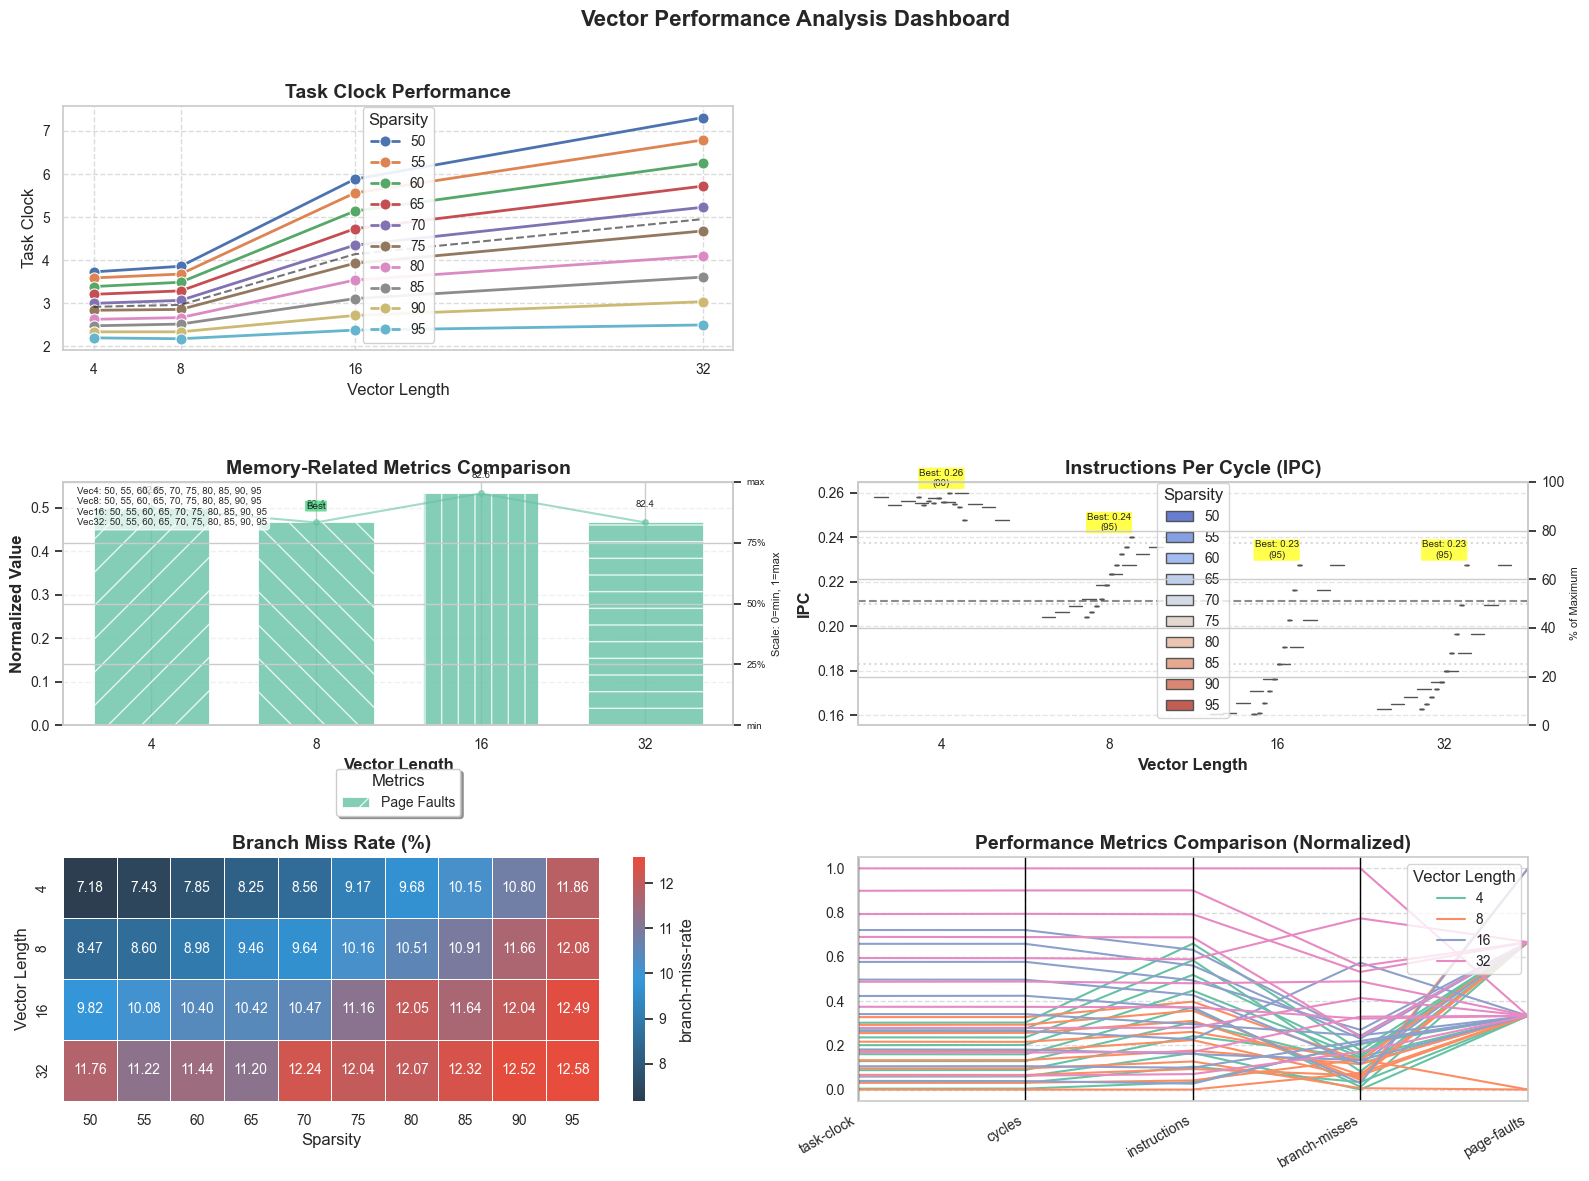

In [62]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from typing import List, Dict, Tuple, Optional

class VectorPerformanceAnalyzer:
    """Class for analyzing vector performance metrics across different configurations."""
    
    def __init__(self, base_dir: str, subdirs: List[str], metrics: List[str]):
        """
        Initialize the analyzer with paths and metrics to analyze.
        
        Args:
            base_dir: Base directory containing results
            subdirs: List of subdirectories to scan
            metrics: Performance metrics to extract
        """
        self.base_dir = base_dir
        self.subdirs = subdirs
        self.metrics = metrics
        self.df = None
        self.custom_palette = sns.color_palette("viridis", len(subdirs))
        # Create a custom colormap for heatmaps
        self.heat_cmap = LinearSegmentedColormap.from_list("vector_performance", 
                                                          ["#2c3e50", "#3498db", "#e74c3c"])
    
    def extract_data(self, stride_filter: str = "stride_1") -> pd.DataFrame:
        """
        Extract performance data from files.
        
        Args:
            stride_filter: Only process files containing this stride pattern
            
        Returns:
            DataFrame with processed performance data
        """
        data = []
        
        # Scan directories and extract relevant files
        for subdir in self.subdirs:
            path = os.path.join(self.base_dir, subdir)
            if not os.path.exists(path):
                print(f"Warning: Path {path} does not exist")
                continue
                
            vector_length = int(subdir.split("_")[-1])
            
            for file in os.listdir(path):
                if stride_filter in file:
                    try:
                        file_path = os.path.join(path, file)
                        # Extract sparsity level from filename more robustly
                        file_parts = file.split("_")
                        sparsity_idx = [i for i, part in enumerate(file_parts) if "sparsity" in part]
                        
                        if sparsity_idx:
                            sparsity = file_parts[sparsity_idx[0] + 1]
                        else:
                            # Fallback to previous method
                            sparsity = file.split("_")[-2]
                        
                        # Read and parse file
                        with open(file_path, "r") as f:
                            lines = f.readlines()
                        
                        entry = {
                            "vector_length": vector_length, 
                            "sparsity": sparsity,
                            "file": file  # Keep filename for reference
                        }
                        
                        # Extract metrics from file content
                        for line in lines:
                            parts = line.strip().split(",")
                            if len(parts) >= 3 and parts[2] in self.metrics:
                                try:
                                    entry[parts[2]] = float(parts[0])
                                except ValueError:
                                    print(f"Warning: Could not parse value in {file}: {line}")
                        
                        # Calculate derived metrics
                        if "cycles" in entry and "instructions" in entry:
                            entry["IPC"] = entry["instructions"] / entry["cycles"]
                        
                        if "branch-misses" in entry and "branches" in entry and entry["branches"] > 0:
                            entry["branch-miss-rate"] = entry["branch-misses"] / entry["branches"] * 100
                        
                        data.append(entry)
                    except Exception as e:
                        print(f"Error processing {file}: {str(e)}")
        
        # Convert to DataFrame and handle multi-index
        df = pd.DataFrame(data)
        
        if df.empty:
            print("Warning: No data found matching criteria")
            return df
            
        # Ensure sparsity is treated as categorical for better plotting
        df["sparsity"] = pd.Categorical(df["sparsity"], 
                                        sorted(df["sparsity"].unique()), 
                                        ordered=True)
        
        # Create multi-index for easier slicing
        if "vector_length" in df.columns and "sparsity" in df.columns:
            df.set_index(["vector_length", "sparsity"], inplace=True)
            df = df.sort_index()
        
        self.df = df
        return df
    
    def create_dashboard(self, output_file: Optional[str] = None):
        """
        Generate a comprehensive performance dashboard.
        
        Args:
            output_file: If provided, save figure to this file
        """
        if self.df is None or self.df.empty:
            print("No data available for plotting")
            return
            
        # Reset index for easier plotting
        plot_df = self.df.reset_index()
        
        # Create dashboard layout
        fig = plt.figure(figsize=(16, 12))
        gs = GridSpec(3, 2, figure=fig)
        
        # Set global style
        sns.set_style("whitegrid")
        plt.rcParams.update({
            'font.size': 10,
            'axes.titlesize': 14,
            'axes.labelsize': 12,
            'xtick.labelsize': 10,
            'ytick.labelsize': 10,
            'legend.fontsize': 10,
        })
        
        # 1. Task Clock Performance
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_metric_by_vector_length(ax1, "task-clock", "Task Clock Performance")
        
        
        # 3. Memory-related Metrics
        ax3 = fig.add_subplot(gs[1, 0])
        mem_metrics = [m for m in self.df.columns if m in ["page-faults"]]
        if mem_metrics:
            self._plot_memory_metrics(ax3, mem_metrics)
        
        # 4. Instructions Per Cycle (IPC)
        ax4 = fig.add_subplot(gs[1, 1])
        if "IPC" in self.df.columns:
            self._plot_efficiency_metrics(ax4, "IPC", "Instructions Per Cycle (IPC)")
        elif "cycles" in self.df.columns and "instructions" in self.df.columns:
            plot_df["IPC"] = plot_df["instructions"] / plot_df["cycles"]
            self._create_sparsity_grouped_bar(ax4, "IPC", "Instructions Per Cycle (IPC)")
        
        # 5. Branch Miss Rate Heatmap
        ax5 = fig.add_subplot(gs[2, 0])
        if "branch-miss-rate" in self.df.columns:
            self._create_heatmap(ax5, "branch-miss-rate", "Branch Miss Rate (%)")
        elif "branch-misses" in self.df.columns and "branches" in self.df.columns:
            plot_df["branch-miss-rate"] = (plot_df["branch-misses"] / plot_df["branches"]) * 100
            self._create_heatmap(ax5, "branch-miss-rate", "Branch Miss Rate (%)")
            
        # 6. Performance Summary - Use a parallel coordinates plot instead of radar chart
        ax6 = fig.add_subplot(gs[2, 1])
        self._create_parallel_coordinates(ax6)
            
        # Add a super title
        plt.suptitle("Vector Performance Analysis Dashboard", fontsize=16, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        
        if output_file:
            plt.savefig(output_file, dpi=300, bbox_inches="tight")
            print(f"Dashboard saved to {output_file}")
        
        return fig
    
    def _plot_metric_by_vector_length(self, ax, metric, title):
        """Create a line plot showing how a metric scales with vector length."""
        if self.df is None or metric not in self.df.columns:
            ax.text(0.5, 0.5, f"No data for {metric}", ha="center", va="center")
            return
            
        plot_df = self.df.reset_index()
        
        # Line plot with error bands
        sns.lineplot(
            data=plot_df, 
            x="vector_length", 
            y=metric, 
            hue="sparsity",
            marker="o",
            markersize=8,
            linewidth=2,
            ax=ax
        )
        
        ax.set_title(title)
        ax.set_xlabel("Vector Length")
        ax.set_ylabel(metric.replace("-", " ").title())
        ax.grid(True, linestyle="--", alpha=0.7)
        
        # Add trend line for the median value across sparsities
        medians = plot_df.groupby("vector_length")[metric].median().reset_index()
        ax.plot(medians["vector_length"], medians[metric], 'k--', linewidth=1.5, alpha=0.6)
        
        # Format legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title="Sparsity", loc="best", frameon=True, framealpha=0.9)
        
        # Set x-ticks to exactly match vector lengths
        ax.set_xticks(sorted(plot_df["vector_length"].unique()))



    def _plot_instruction_cycle_relationship(self, ax):
        """Create an enhanced scatter plot of cycles vs instructions with regression line."""
        if self.df is None or "cycles" not in self.df.columns or "instructions" not in self.df.columns:
            ax.text(0.5, 0.5, "No cycle/instruction data", ha="center", va="center")
            return
            
        plot_df = self.df.reset_index()
        
        # Create scatter plot with improved visual encoding
        scatter = sns.scatterplot(
            data=plot_df,
            x="cycles",
            y="instructions",
            hue="sparsity",
            size="vector_length",
            sizes=(80, 250),  # Increased point sizes for better visibility
            alpha=0.7,
            edgecolor='w',    # White edges to make points stand out
            linewidth=0.5,
            palette="viridis",
            ax=ax
        )
        
        # Add regression line for each sparsity group
        sparsity_values = sorted(plot_df["sparsity"].unique())
        for sparsity in sparsity_values:
            subset = plot_df[plot_df["sparsity"] == sparsity]
            if len(subset) >= 2:  # Need at least 2 points for regression
                sns.regplot(
                    x="cycles",
                    y="instructions",
                    data=subset,
                    scatter=False,
                    ci=None,
                    line_kws={"linestyle": "--", "alpha": 0.7, "linewidth": 1},
                    ax=ax
                )
        
        # Add annotations for vector lengths with better positioning
        for _, row in plot_df.iterrows():
            ax.annotate(f"{row['vector_length']}", 
                    (row["cycles"], row["instructions"]),
                    xytext=(7, 0),
                    textcoords="offset points",
                    fontsize=8,
                    alpha=0.8,
                    bbox=dict(boxstyle="round,pad=0.1", fc="white", alpha=0.7, ec="none"))
        
        # Add diagonal line representing 1:1 IPC ratio
        if len(plot_df) > 1:
            x_min, x_max = ax.get_xlim()
            y_min, y_max = ax.get_ylim()
            lims = [max(x_min, y_min), min(x_max, y_max)]
            ax.plot(lims, lims, 'k--', alpha=0.5, zorder=0, label="1:1 IPC Ratio")
            
            # Add additional IPC reference lines
            ipc_values = [0.5, 2]
            ipc_colors = ['#e74c3c', '#2ecc71']
            ipc_labels = ['IPC = 0.5', 'IPC = 2']
            
            for ipc, color, label in zip(ipc_values, ipc_colors, ipc_labels):
                ax.plot([lims[0], lims[1]], [lims[0]*ipc, lims[1]*ipc], 
                    linestyle=':', color=color, alpha=0.7, 
                    label=label)
        
        ax.set_title("Cycles vs Instructions Relationship", fontweight='bold')
        ax.set_xlabel("Cycles", fontweight='bold')
        ax.set_ylabel("Instructions", fontweight='bold')
        ax.grid(True, linestyle="--", alpha=0.5)
        
        # Add text annotations showing IPC values for key data points
        for _, row in plot_df.iterrows():
            if "cycles" in row and "instructions" in row and row["cycles"] > 0:
                ipc = row["instructions"] / row["cycles"]
                ax.annotate(f"IPC: {ipc:.2f}", 
                        (row["cycles"], row["instructions"]),
                        xytext=(7, -12),
                        textcoords="offset points",
                        fontsize=7,
                        alpha=0.7)
        
        # Improve legend with separate sections for different information types
        handles, labels = ax.get_legend_handles_labels()
        
        # Split into sparsity, vector length, and IPC reference lines
        sparsity_handles = handles[:len(sparsity_values)]
        sparsity_labels = labels[:len(sparsity_values)]
        
        # Create custom legend for vector lengths
        vector_handles = []
        vector_labels = []
        vector_lengths = sorted(plot_df["vector_length"].unique())
        for vl in vector_lengths:
            vector_handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                        markerfacecolor='gray', markersize=np.sqrt(6+vl/8)))
            vector_labels.append(str(vl))
        
        # Add IPC reference line handles
        ipc_handles = handles[-3:]  # Last 3 handles are the IPC reference lines
        ipc_labels = labels[-3:]
        
        # Create combined legend
        ax.legend(sparsity_handles + vector_handles + ipc_handles,
                sparsity_labels + vector_labels + ipc_labels,
                title="Sparsity & Vector Length",
                loc="best",
                frameon=True,
                framealpha=0.9,
                ncol=1)

    def _plot_memory_metrics(self, ax, metrics):
        """Create an enhanced grouped bar chart with trend lines for memory-related metrics."""
        if self.df is None:
            ax.text(0.5, 0.5, "No memory metrics data", ha="center", va="center")
            return
            
        # Get data ready
        plot_df = self.df.reset_index()
        vector_lengths = sorted(plot_df["vector_length"].unique())
        
        # For better visual comparison, normalize metrics to a common scale
        norm_df = plot_df.copy()
        for metric in metrics:
            max_val = plot_df[metric].max()
            min_val = plot_df[metric].min()
            if max_val > min_val:
                norm_df[f"{metric}_norm"] = (plot_df[metric] - min_val) / (max_val - min_val)
            else:
                norm_df[f"{metric}_norm"] = 0.5
        
        # Plot normalized metrics as grouped bars with enhanced styling
        bar_width = 0.7 / len(metrics)
        colors = sns.color_palette("Set2", len(metrics))
        
        # Set x positions for bars
        x_pos = np.arange(len(vector_lengths))
        
        # Add bars for each metric
        for i, metric in enumerate(metrics):
            # Get the normalized metric values
            metric_values = []
            for length in vector_lengths:
                subset = norm_df[norm_df["vector_length"] == length]
                avg_value = subset[f"{metric}_norm"].mean()
                metric_values.append(avg_value)
            
            # Plot bars
            positions = x_pos + (i - len(metrics)/2 + 0.5) * bar_width
            bars = ax.bar(positions, metric_values, width=bar_width, 
                        label=metric.replace("-", " ").title(), 
                        color=colors[i], alpha=0.8,
                        edgecolor='white', linewidth=0.7)
            
            # Add actual values as text
            for j, bar in enumerate(bars):
                height = bar.get_height()
                actual_value = plot_df[plot_df["vector_length"] == vector_lengths[j]][metric].mean()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.03,
                    f"{actual_value:.1f}",
                    ha='center', va='bottom', fontsize=7, rotation=0)
        
        # Add connecting lines between same metrics (as a trend line)
        for i, metric in enumerate(metrics):
            trend_data = []
            for j, length in enumerate(vector_lengths):
                subset = norm_df[norm_df["vector_length"] == length]
                avg_value = subset[f"{metric}_norm"].mean()
                trend_data.append((x_pos[j] + (i - len(metrics)/2 + 0.5) * bar_width, avg_value))
            
            # Plot line connecting points
            xs, ys = zip(*trend_data)
            ax.plot(xs, ys, 'o-', color=colors[i], alpha=0.6, linewidth=1.5, markersize=4)
        
        # Add crosshatch pattern to bars for better visual distinction
        patterns = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
        for i, bar in enumerate(ax.patches):
            bar.set_hatch(patterns[i % len(patterns)])
        
        # Add sparsity information as a small table in the corner
        sparsity_values = sorted(plot_df["sparsity"].unique())
        table_text = []
        for vl in vector_lengths:
            subset = plot_df[plot_df["vector_length"] == vl]
            sparses = subset["sparsity"].unique()
            table_text.append(f"Vec{vl}: {', '.join(sparses)}")
        
        # Create a text box with sparsity information
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax.text(0.02, 0.98, '\n'.join(table_text), transform=ax.transAxes,
            fontsize=7, verticalalignment='top', bbox=props)
        
        # Improve styling
        ax.set_title("Memory-Related Metrics Comparison", fontweight='bold')
        ax.set_xlabel("Vector Length", fontweight='bold')
        ax.set_ylabel("Normalized Value", fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(vector_lengths)
        ax.grid(True, linestyle='--', alpha=0.3, axis='y')
        
        # Add a twin axis on the right to show scale information
        ax_right = ax.twinx()
        ax_right.set_ylabel("Scale: 0=min, 1=max", fontsize=8)
        ax_right.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        ax_right.set_yticklabels(['min', '25%', '50%', '75%', 'max'])
        ax_right.tick_params(axis='y', labelsize=7)
        
        # Create a unified legend
        ax.legend(title="Metrics", loc="upper center", bbox_to_anchor=(0.5, -0.15), 
                fancybox=True, shadow=True, ncol=len(metrics))
        
        # Add annotations for the best (lowest) values
        for i, metric in enumerate(metrics):
            min_idx = np.argmin([plot_df[plot_df["vector_length"] == vl][metric].mean() for vl in vector_lengths])
            x = x_pos[min_idx] + (i - len(metrics)/2 + 0.5) * bar_width
            y = norm_df[norm_df["vector_length"] == vector_lengths[min_idx]][f"{metric}_norm"].mean()
            ax.annotate("Best", xy=(x, y), xytext=(0, 10), 
                    textcoords="offset points", ha='center', fontsize=7,
                    bbox=dict(boxstyle="round,pad=0.1", fc="#2ecc71", alpha=0.7, ec="none"))

    def _plot_efficiency_metrics(self, ax, metric, title):
        """Create an enhanced visualization for efficiency metrics with boxplots and violin plots."""
        if self.df is None or metric not in self.df.columns:
            ax.text(0.5, 0.5, f"No data for {metric}", ha="center", va="center")
            return
            
        plot_df = self.df.reset_index()
        
        # Create a more informative visualization with both violin and boxplot
        # The violinplot shows distribution, while boxplot shows key statistics
        sns.violinplot(
            data=plot_df,
            x="vector_length",
            y=metric,
            hue="sparsity",
            palette="coolwarm",
            split=False,  # Don't split violins
            inner=None,   # No inner points - we'll add a boxplot for this
            linewidth=1,
            cut=0,        # Don't extend beyond data range
            ax=ax,
            saturation=0.75
        )
        
        # Add a thin boxplot inside the violin for showing quartiles
        sns.boxplot(
            data=plot_df,
            x="vector_length",
            y=metric,
            hue="sparsity",
            palette="coolwarm",
            width=0.3,    # Narrow width
            ax=ax,
            boxprops=dict(alpha=0.7),
            showfliers=False,  # Don't show outlier points
            dodge=True
        )
        
        # Remove the second legend that boxplot added
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:len(plot_df["sparsity"].unique())], 
                labels[:len(plot_df["sparsity"].unique())], 
                title="Sparsity", 
                loc="best")
        
        # Add a horizontal line for the mean across all data
        mean_val = plot_df[metric].mean()
        ax.axhline(y=mean_val, color='k', linestyle='--', alpha=0.5, 
                label=f"Mean: {mean_val:.2f}")
        
        # Add text annotations for optimal values
        for vl in sorted(plot_df["vector_length"].unique()):
            subset = plot_df[plot_df["vector_length"] == vl]
            best_idx = subset[metric].idxmax()  # For IPC, higher is better
            best_sparsity = subset.iloc[subset.index.get_indexer([best_idx])]["sparsity"].values[0]
            best_val = subset.iloc[subset.index.get_indexer([best_idx])][metric].values[0]
            
            # Find position on plot (approximate)
            x_pos = list(sorted(plot_df["vector_length"].unique())).index(vl)
            ax.annotate(f"Best: {best_val:.2f}\n({best_sparsity})", 
                    xy=(x_pos, best_val),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center',
                    fontsize=7,
                    bbox=dict(boxstyle="round,pad=0.1", fc="yellow", alpha=0.7, ec="none"))
        
        # Improve styling
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel("Vector Length", fontweight='bold')
        ax.set_ylabel(metric, fontweight='bold')
        ax.grid(True, linestyle="--", alpha=0.5, axis='y')
        
        # Add a second y-axis with a normalized scale if there's enough variation
        y_min, y_max = ax.get_ylim()
        if y_max - y_min > 0.1:  # Only add if there's meaningful variation
            ax_right = ax.twinx()
            ax_right.set_ylim(0, 100)
            ax_right.set_ylabel("% of Maximum", fontsize=8)
            
            # Add reference lines for percentages
            for pct in [25, 50, 75]:
                y_val = y_min + (y_max - y_min) * pct/100
                ax.axhline(y=y_val, color='gray', linestyle=':', alpha=0.3)

        
        
    
    def _create_sparsity_grouped_bar(self, ax, metric, title):
        """Create a grouped bar chart by sparsity."""
        if self.df is None:
            ax.text(0.5, 0.5, f"No data for {metric}", ha="center", va="center")
            return
            
        plot_df = self.df.reset_index() if hasattr(self.df, 'reset_index') else self.df
        
        if metric not in plot_df.columns:
            ax.text(0.5, 0.5, f"No data for {metric}", ha="center", va="center")
            return
        
        # Create grouped bar plot
        sns.barplot(
            data=plot_df,
            x="vector_length",
            y=metric,
            hue="sparsity",
            palette="coolwarm",
            ax=ax
        )
        
        # Add value labels on bars
        for i, bar in enumerate(ax.patches):
            height = bar.get_height()
            if not np.isnan(height):
                ax.text(
                    bar.get_x() + bar.get_width() / 2.,
                    height + 0.02,
                    f"{height:.2f}",
                    ha='center', 
                    va='bottom',
                    fontsize=8,
                    rotation=45
                )
        
        ax.set_title(title)
        ax.set_xlabel("Vector Length")
        ax.set_ylabel(metric)
        ax.grid(True, linestyle="--", alpha=0.7)
        
        # Improve legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title="Sparsity", loc="best")
    
    def _create_heatmap(self, ax, metric, title):
        """Create a heatmap for a metric across vector lengths and sparsities."""
        if self.df is None or metric not in self.df.columns:
            ax.text(0.5, 0.5, f"No data for {metric}", ha="center", va="center")
            return
            
        # Pivot the data for heatmap format
        plot_df = self.df.reset_index()
        pivot_data = plot_df.pivot(index="vector_length", columns="sparsity", values=metric)
        
        # Create heatmap
        sns.heatmap(
            pivot_data,
            annot=True,
            fmt=".2f",
            cmap=self.heat_cmap,
            linewidths=0.5,
            ax=ax,
            cbar_kws={"label": metric}
        )
        
        ax.set_title(title)
        ax.set_xlabel("Sparsity")
        ax.set_ylabel("Vector Length")
    
    def _create_parallel_coordinates(self, ax):
        """Create a parallel coordinates plot for multi-dimensional visualization."""
        if self.df is None:
            ax.text(0.5, 0.5, "No data for parallel coordinates", ha="center", va="center")
            return
            
        # Select metrics to include
        pc_metrics = ["task-clock", "cycles", "instructions", "branch-misses", "page-faults"]
        pc_metrics = [m for m in pc_metrics if m in self.df.columns]
        
        if len(pc_metrics) < 2:
            ax.text(0.5, 0.5, "Not enough metrics for parallel coordinates", ha="center", va="center")
            return
        
        # Prepare the data
        plot_df = self.df.reset_index()
        
        # Normalize data for better visualization
        norm_df = plot_df.copy()
        for metric in pc_metrics:
            max_val = plot_df[metric].max()
            min_val = plot_df[metric].min()
            if max_val > min_val:
                norm_df[metric] = (plot_df[metric] - min_val) / (max_val - min_val)
            else:
                norm_df[metric] = 0.5  # If all values are the same
        
        # Create parallel coordinates plot
        pd.plotting.parallel_coordinates(
            norm_df, 
            'vector_length', 
            cols=pc_metrics,
            color=plt.cm.Set2.colors,
            ax=ax
        )
        
        ax.set_title("Performance Metrics Comparison (Normalized)")
        ax.grid(True, linestyle="--", alpha=0.7)
        
        # Improve legend position
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title="Vector Length", loc="upper right")
        
        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    
    def generate_summary_statistics(self) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Generate summary statistics for each metric across vector lengths and sparsities.
        
        Returns:
            Tuple of DataFrames with summary statistics and improvement metrics
        """
        if self.df is None or self.df.empty:
            print("No data available for statistics")
            return pd.DataFrame(), None
        
        # Group by vector_length and sparsity to get mean, min, max for each metric
        summary = self.df.groupby(level=['vector_length', 'sparsity']).agg(['mean', 'min', 'max', 'std'])
        
        # Calculate improvement ratios across vector lengths
        vector_lengths = sorted(self.df.index.get_level_values('vector_length').unique())
        if len(vector_lengths) > 1:
            base_length = min(vector_lengths)
            
            improvement_data = []
            
            for metric in self.metrics:
                if metric in self.df.columns:
                    for length in vector_lengths:
                        if length != base_length:
                            for sparsity in self.df.index.get_level_values('sparsity').unique():
                                try:
                                    # Get the base and current metric values
                                    base_val = self.df.loc[(base_length, sparsity), metric]
                                    current_val = self.df.loc[(length, sparsity), metric]
                                    
                                    # Calculate improvement ratio (lower is better for most metrics)
                                    ratio = base_val / current_val if current_val != 0 else float('inf')
                                    
                                    improvement_data.append({
                                        'vector_length': length,
                                        'sparsity': sparsity,
                                        'metric': metric,
                                        'improvement_ratio': ratio,
                                        'percent_change': (current_val - base_val) / base_val * 100 if base_val != 0 else float('inf')
                                    })
                                except (KeyError, TypeError):
                                    continue
            
            if improvement_data:
                improvement_df = pd.DataFrame(improvement_data)
                improvement_df.set_index(['vector_length', 'sparsity', 'metric'], inplace=True)
                return summary, improvement_df
        
        return summary, None


# Set up the analyzer
base_dir = "results_vector"
subdirs = subdirs
metrics = ["task-clock", "page-faults", 
           "cycles", "instructions", "branches", "branch-misses"]

analyzer = VectorPerformanceAnalyzer(base_dir, subdirs, metrics)

# Extract data
df = analyzer.extract_data(stride_filter="stride_1")
print("Vector lengths analyzed:", df.index.get_level_values('vector_length').unique())
# Generate the dashboard
fig = analyzer.create_dashboard(output_file="vector_performance_dashboard.png")

# Get summary statistics
try:
    summary_stats, improvement_stats = analyzer.generate_summary_statistics()
    
    # Display results
    print("Vector Performance Analysis Complete")
    print(f"Analyzed {len(df)} data points across {len(subdirs)} vector lengths")
    
    # Show data statistics
    print("\nData Preview:")
    print(df.head())
    
    # Show summary statistics
    print("\nSummary Statistics:")
    print(summary_stats.head())
    
    # Show improvement metrics
    if improvement_stats is not None:
        print("\nPerformance Improvement Metrics (vs. smallest vector length):")
        print(improvement_stats.head())
except Exception as e:
    print(f"Error generating statistics: {str(e)}")

plt.show()